## 数値微分
関数 $f(x)$ と微小変化 $h$ より微分係数を数値的に求めることができます。

$$
\frac{df(x)}{dx} = \lim_{h \rightarrow 0}\frac{f(x+h) - f(x)}{h}
$$

例えば、$f(x) = x^2$ で、$x=1$において、$h=0.1$の時の微分係数は下記のようになります。

In [2]:
x = 1
h = 0.1
((x+h)**2 - x**2) / h

2.100000000000002

## 偏微分
NISQでよく用いられるパラメータ付き量子回路では、たくさんの角度が回路に変数パラメータとして登場します。  
偏微分によって、特定のパラメータにおける微分係数を求めることができます。

$f(x, y)$ の $x$ についての偏微分

$$
\frac{\partial f(x,y)}{\partial x}
$$

$f(x, y)$ の $y$ についての偏微分

$$
\frac{\partial f(x,y)}{\partial y}
$$

## 勾配
勾配は、各パラメータについての偏微分をベクトルの形式で書いたものです。

$$
(\frac{\partial f(x,y)}{\partial x},\frac{\partial f(x,y)}{\partial y})
$$

勾配は関数が極小値、最小値をとる点(まとめて極小点とします)を求めるために役立ちます。  
極小点では微分が0になり、その周り(近傍)の点は正、または負の傾きを持ちます。

- 現在地点の座標が極小点より大きい値の場合、傾きは正です。よって現在地座標から傾きを引くと極小点に近づけます。
- 現在地点の座標が極小点より小さい値の場合、傾きは負です。よってやはり、現在地座標から傾きを引くと極小点に近づけます。

以上から、勾配を用いて現在地を更新することによって極小点を探すことができます。$e$ はここでは学習率を示します。

$$
x' = x -e\cdot\frac{\partial f(x,y)}{\partial x}\\
y' = y -e\cdot\frac{\partial f(x,y)}{\partial y}
$$

このプロセスを繰り返します。

## 勾配降下法
RYゲートを使った回路で、測定の期待値の最小値を求めるVQEをやってみます。

In [3]:
!pip install -q blueqat

You should consider upgrading via the 'pip install --upgrade pip' command.


3.1411949016315885


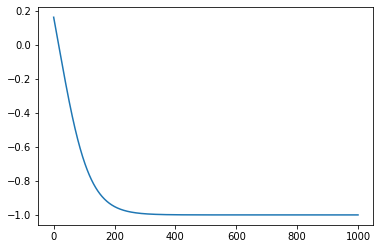

In [5]:
from blueqat import Circuit
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def abs_sq(k):
    return np.square(np.abs(k))

#Zの期待値
def exptZ(a):
    res = Circuit().ry(a)[0].run()
    return abs_sq(res[0]) - abs_sq(res[1])

#初期設定
ainit = [np.random.rand()*2*np.pi]
a = ainit.copy()
h = 0.001
e = 0.01

#勾配の更新と記録
for i in range(1000):
    a.append(a[i] - e*(exptZ(a[i]+h) - exptZ(a[i]))/h)

#最終の値
print(a[-1])

#期待値のプロット
plt.plot(list(map(exptZ, a)))
plt.show()

1量子ビットの $Z$ 測定期待値が最小となるのは、状態が $\lvert 1 \rangle$ のときです。  
期待値最小化後の $RY$ ゲート回転角は約 $\pi = 3.14...$ であり、初期状態 $\lvert 0 \rangle$ を $\lvert 1 \rangle$ に変えます。  
以上から、VQEができました。

## パラメータシフト則

参考文献: arXiv:1803.00745 [quant-ph] (https://arxiv.org/abs/1803.00745)

微小変化 $h$ を用いた数値微分は実際の量子コンピュータで実行する上で課題があります。  
量子コンピュータによって計算される期待値は、サンプリングやノイズに起因するばらつきを伴います。微小変化 $h$ が小さすぎるとそれらのばらつきに埋もれてしまい、大きすぎると数値微分の精度が悪くなります。よって $h$ をハイパーパラメータとして調整する必要が生じます。

このような背景から、量子コンピュータにおいて勾配を算出する手法についても研究が進められています。  
ここでは代表的な "パラメータシフト則" を紹介します。

ある観測量 $\hat{B}$ の期待値 $\langle \hat{B}\rangle$ とします。  
パウリ回転ゲート$U(\theta) = \exp{(-i\theta P)}\ \ (P\in \{X, Y, Z, I\})$ 中のパラメータ$\theta$について、$\langle \hat{B}\rangle$ の勾配は以下のように求められます。  


$$\frac{\partial \langle \hat{B}\rangle}{\partial \theta} = \frac{1}{2} \bigl(\langle \hat{B}\rangle_+ - \langle \hat{B}\rangle_- \bigr)$$

$$U(\theta + \frac{\pi}{2}) = \langle \hat{B}\rangle_+$$
$$U(\theta - \frac{\pi}{2}) = \langle \hat{B}\rangle_-$$

つまり、傾きを求めたいパラメータ1つ1つについて $+\frac{\pi}{2}$, $-\frac{\pi}{2}$ シフトした量子回路を実行して期待値をそれぞれ求めれば良いことになります。  
この手法では微小変化 $h$ の代わりに固定かつ十分に大きいシフト量 $\pm\frac{\pi}{2}$ を用いるため、上記の課題を解決することが可能です。  

これは$RX(\theta)$ゲート, $RY(\theta)$ゲート, $RZ(\theta)$ゲートなどのパラメータ $\theta$ に適用可能です。これに2量子ビットエンタングルゲートを組み合わせることで、汎用的な量子古典ハイブリッド機械学習回路を構築することが可能です。

以下はパラメータシフト則を用いて、先程の勾配降下法の例を再び計算しています。

3.141732372485875


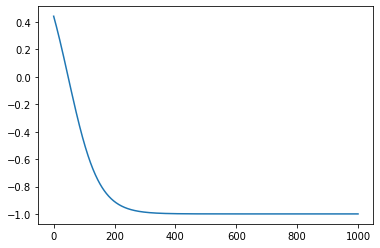

In [7]:
#初期設定
ainit = [np.random.rand()*2*np.pi]
a = ainit.copy()
e = 0.01

#勾配の更新と記録
for i in range(1000):
    grad = (exptZ(a[i]+np.pi/2) - exptZ(a[i]-np.pi/2)) / 2
    a.append(a[i] - e*grad)

#最終の値
print(a[-1])

#期待値のプロット
plt.plot(list(map(exptZ, a)))
plt.show()

## 損失関数
VQEでは測定の期待値を最小化しますが、上のような考え方では最小化の対象は必ずしも測定期待値でなくても良いです。  
ここではより一般的な損失関数を定義し、使ってみます。こうすると機械学習として覚えられます。

3.3233131527307167


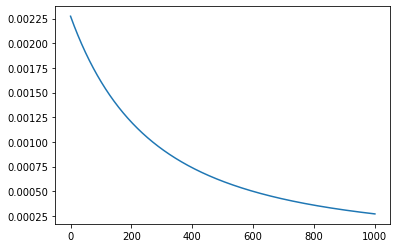

0.00027112202406906325


In [10]:
from blueqat import Circuit
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def abs_sq(k):
    return np.square(np.abs(k))

#期待値
def expt(a):
    res = Circuit().ry(a)[0].run()
    return abs_sq(res[0])-abs_sq(res[1])

#損失関数
def loss(res,tar):
    return np.square(res-tar)

#微分係数
def dfx(a,h,tgt=-1):
    return (loss(expt(a+h),tgt) - loss(expt(a),tgt))/h
#    return (expt(a+h)-expt(a))/h

#勾配
def grad(a,h,e):
    for i in range(1000):
        a.append(a[i] - e*dfx(a[i],h))
    return a

#初期化
a = [np.random.rand()*2*np.pi]
h = 0.001
e = 0.01

ra = grad(a,h,e)
print(ra[-1])

arr = [loss(expt(i),-1) for i in ra]

plt.plot(arr)
plt.show()

print(arr[-1])

## momentum SGD

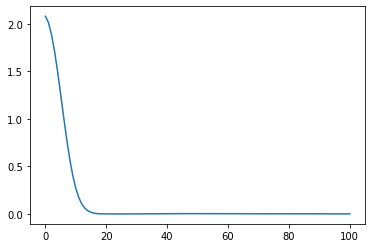

In [11]:
#momentum sgd
def msgd(a,h,e,tgt,alpha):
    p_delta = 0
    for i in range(100):
        update = -e*dfx(a[i],h,tgt) + alpha*p_delta
        a.append(a[i] + update)
        p_delta = update
    return a

#initialization
a = ainit.copy()
h = 0.001
e = 0.01

alpha = 0.9
tgt = -1

result = msgd(a,h,e,tgt,alpha)
arr = [loss(expt(i),tgt) for i in result]

plt.plot(arr)
plt.show()

## Adagrad

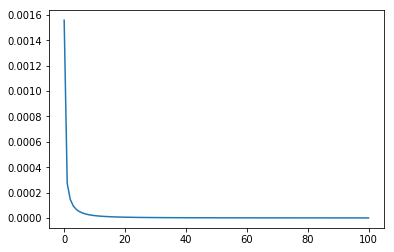

In [13]:
def adagrad(a,h,e,tgt,epsilon):
    G = epsilon
    for i in range(100):
        g = dfx(a[i],h,tgt)
        G += g*g
        update = -e/np.sqrt(G)*g
        a.append(a[i] + update)
    return a

#initialization
a = ainit.copy()
h = 0.001
e = 0.1
epsilon = 1e-08
tgt = -1

result = adagrad(a,h,e,tgt,epsilon)
arr = [loss(expt(i),tgt) for i in result]

plt.plot(arr)
plt.show()